STAT 451: Machine Learning (Fall 2020)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat451-fs2020/

# L09: Model Evaluation 2 -- Confidence Intervals and Resampling

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p numpy,mlxtend,matplotlib,sklearn

Sebastian Raschka 
last updated: 2020-11-10 

CPython 3.8.2
IPython 7.18.1

numpy 1.18.5
mlxtend 0.18.0.dev0
matplotlib 3.3.1
sklearn 0.23.2


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# 1. Iris Feature by Class Distribution in Random Subsampling

### (Just for your reference to see that we used real data)

The following code will randomly divide the iris dataset into a 100-example training and 50-example test dataset to illustrate the issues that occur in non-stratified subsampling. I.e., the proportion of class labels in the training set will differ from the original dataset. Even worse, the proportion of class labels in the test set will be different too, depending on what the class label proportion is in the training set.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mlxtend.data import iris_data
from mlxtend.preprocessing import shuffle_arrays_unison

X, y = iris_data()

X, y = shuffle_arrays_unison([X, y], random_seed=123)
X_train, X_test = X[:100], X[100:150]
y_train, y_test = y[:100], y[100:150]

In [4]:
np.bincount(y)

array([50, 50, 50])

In [5]:
np.bincount(y_train)

array([38, 28, 34])

In [6]:
np.bincount(y_test)

array([12, 22, 16])

In [7]:
df = pd.DataFrame(X)
df['class'] = y

df_train = pd.DataFrame(X_train)
df_train['class'] = y_train

df_test = pd.DataFrame(X_test)
df_test['class'] = y_test

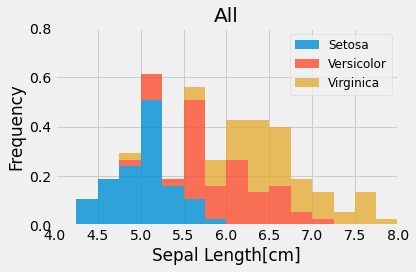

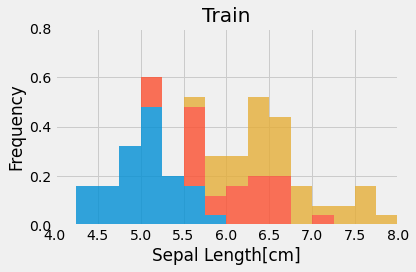

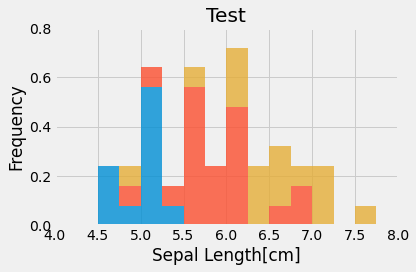

In [8]:
def stackhist(x, y, **kws):
    grouped = x.groupby(y)
    data = [d for _, d in grouped]
    labels = [l for l, _ in grouped]
    plt.hist(data, 
             histtype="barstacked", 
             label=labels, 
             alpha=0.8, 
             density=True,
             bins=np.arange(4.0, 8.1, 0.25))
    plt.ylim([0, 0.8])
    plt.xlim([4, 8])
    plt.xlabel('Sepal Length[cm]')
    plt.ylabel('Frequency')
    

with plt.style.context('fivethirtyeight'):    

    stackhist(df[0], df['class'])
    plt.legend(['Setosa', 'Versicolor', 'Virginica'], fontsize=12)
    plt.title('All')
    plt.tight_layout()
    #plt.savefig('./all.svg')
    plt.show()    

    stackhist(df_train[0], df_train['class'])
    plt.title('Train')
    plt.tight_layout()
    #plt.savefig('./train.svg')
    plt.show()    

    stackhist(df_test[0], df_test['class'])
    plt.title('Test')
    plt.tight_layout()
    #plt.savefig('./test.svg')
    plt.show() 
    

Note that these problems can be mitigated by using the `stratify` parameter in scikit-learn's [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

# 2. Holdout method and repeated sampling

The following plots illustrate the issue of increasing the pessimistic bias of a performance estimate if we make the test set too large -- because we withold too many examples for model training such that the model doesn't reach it's capacity -- this assumes that we would fit the model on the whole training set after model evaluation. On the other hand, if we decrease the size of the test set, the estimate of the generalization performance will have a larger variance.

**Initialize KNN**

In [9]:
from mlxtend.data import iris_data
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X, y = iris_data()

clf_1 = KNeighborsClassifier(n_neighbors=3,
                             weights='uniform', 
                             algorithm='kd_tree', 
                             leaf_size=30, 
                             p=2, 
                             metric='minkowski', 
                             metric_params=None, 
                             n_jobs=1)

**Large test set <=> small training set**

Average: 95.41%


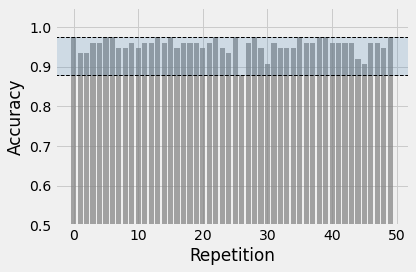

In [10]:
rng = np.random.RandomState(seed=12345)
seeds = np.arange(10**5)
rng.shuffle(seeds)
seeds = seeds[:50]

pred_2 = []

for i in seeds:
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.5, 
                                                        random_state=i,
                                                        stratify=y)
    y_pred_i = clf_1.fit(X_train, y_train).predict(X_test)
    y_pred_i_acc = np.mean(y_test == y_pred_i)
    pred_2.append(y_pred_i_acc)

pred_2 = np.asarray(pred_2)
print('Average: %.2f%%' % (pred_2.mean()*100))

with plt.style.context(('fivethirtyeight')):
    plt.bar(range(0, pred_2.shape[0]), pred_2, color='gray', alpha=0.7)
    plt.axhline(pred_2.max(), color='k', linewidth=1, linestyle='--')
    plt.axhline(pred_2.min(), color='k', linewidth=1, linestyle='--')
    plt.axhspan(pred_2.min(), pred_2.max(), alpha=0.2, color='steelblue')
    plt.ylim([0, pred_2.max() + 0.1])
    plt.xlabel('Repetition')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1.05])
    plt.tight_layout()
    #plt.savefig('figures/model-eval-iris_0.svg')
    plt.show()

**Small test set <=> larger training set**

Average: 96.13%


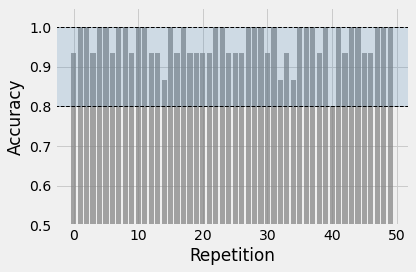

In [11]:
rng = np.random.RandomState(seed=12345)
seeds = np.arange(10**5)
rng.shuffle(seeds)
seeds = seeds[:50]

pred_2 = []

for i in seeds:
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.1, 
                                                        random_state=i,
                                                        stratify=y)
    y_pred_i = clf_1.fit(X_train, y_train).predict(X_test)
    y_pred_i_acc = np.mean(y_test == y_pred_i)
    pred_2.append(y_pred_i_acc)
    
pred_2 = np.asarray(pred_2)
print('Average: %.2f%%' % (pred_2.mean()*100))

with plt.style.context(('fivethirtyeight')):
    plt.bar(range(0, pred_2.shape[0]), pred_2, color='gray', alpha=0.7)
    plt.axhline(pred_2.max(), color='k', linewidth=1, linestyle='--')
    plt.axhline(pred_2.min(), color='k', linewidth=1, linestyle='--')
    plt.axhspan(pred_2.min(), pred_2.max(), alpha=0.2, color='steelblue')
    plt.ylim([0, pred_2.max() + 0.1])
    plt.xlabel('Repetition')
    plt.ylabel('Accuracy')
    plt.ylim(0.5, 1.05)
    plt.tight_layout()
    #plt.savefig('figures/model-eval-iris_0_2.svg')
    plt.show()

<br>
<br>
<br>

# 3. Pessimistic Bias in Holdout

The following experiments further illustrate the issue of the pessimistic bias of the generalization performance estimates using learning curves. Here, the same test set is used while a model is fit on training sets with different sizes.

In [12]:
from mlxtend.data import mnist_data

X2, y2 = mnist_data()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2,
                                                        test_size=0.3, 
                                                        random_state=12,
                                                        stratify=y2)
print('Number of train examples:', y_train2.shape[0])
print('Number of test examples:', y_test2.shape[0])
print('Labels:', y_train2)

Number of train examples: 3500
Number of test examples: 1500
Labels: [8 8 7 ... 6 9 8]


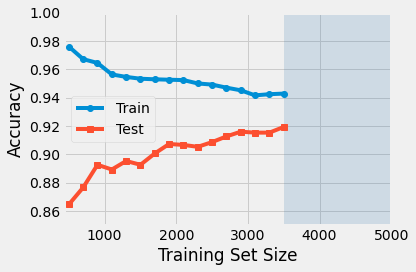

In [13]:
from sklearn.linear_model import LogisticRegression

clf_2 = LogisticRegression(penalty='l2', 
                           dual=False, 
                           tol=0.0001, 
                           C=0.000001, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           class_weight=None, 
                           random_state=12, 
                           solver='lbfgs', 
                           max_iter=1000, 
                           multi_class='multinomial', 
                           verbose=0, 
                           warm_start=False, 
                           n_jobs=1)

pred_train, pred_test = [], []

intervals = np.arange(500, X_train2.shape[0] + 1, 200)

for i in intervals:
    clf_2.fit(X_train2[:i], y_train2[:i])
    p_train = clf_2.score(X_train2[:i], y_train2[:i])
    p_test = clf_2.score(X_test2, y_test2)
    pred_train.append(p_train)
    pred_test.append(p_test)
    
    
with plt.style.context(('fivethirtyeight')):
    plt.plot(intervals, pred_train, marker='o', label='Train')
    plt.plot(intervals, pred_test, marker='s', label='Test')
    plt.legend(loc='best', numpoints=1)
    plt.xlim([430, X_train2.shape[0] + X_test2.shape[0]])
    plt.axvspan(X_train2.shape[0], 
                X_train2.shape[0] + X_test2.shape[0], 
                alpha=0.2, 
                color='steelblue')
    plt.ylim([0.85, 1.0])
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    #plt.savefig('figures/model-eval-mnist_0.svg')

As it can be seen, the model is likely benefitting from more training data.

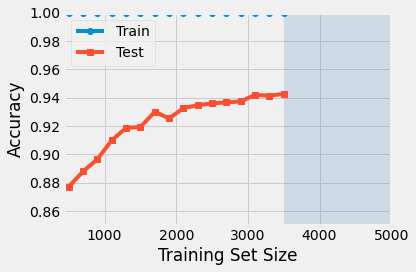

In [14]:
from sklearn.ensemble import RandomForestClassifier


clf_2 = RandomForestClassifier(n_estimators=100, random_state=123)

pred_train, pred_test = [], []

intervals = np.arange(500, X_train2.shape[0] + 1, 200)

for i in intervals:
    clf_2.fit(X_train2[:i], y_train2[:i])
    p_train = clf_2.score(X_train2[:i], y_train2[:i])
    p_test = clf_2.score(X_test2, y_test2)
    pred_train.append(p_train)
    pred_test.append(p_test)
    
    
with plt.style.context(('fivethirtyeight')):
    plt.plot(intervals, pred_train, marker='o', label='Train')
    plt.plot(intervals, pred_test, marker='s', label='Test')
    plt.legend(loc='best', numpoints=1)
    plt.xlim([430, X_train2.shape[0] + X_test2.shape[0]])
    plt.axvspan(X_train2.shape[0], 
                X_train2.shape[0] + X_test2.shape[0], 
                alpha=0.2, 
                color='steelblue')
    plt.ylim([0.85, 1.0])
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    #plt.savefig('figures/model-eval-mnist_0.svg')

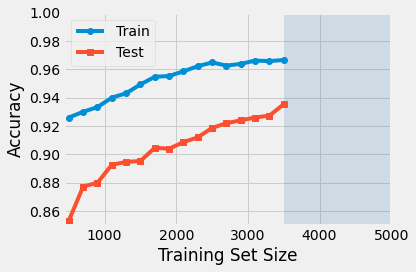

In [15]:
from sklearn.neighbors import KNeighborsClassifier


clf_2 = KNeighborsClassifier(n_neighbors=3)

pred_train, pred_test = [], []

intervals = np.arange(500, X_train2.shape[0] + 1, 200)

for i in intervals:
    clf_2.fit(X_train2[:i], y_train2[:i])
    p_train = clf_2.score(X_train2[:i], y_train2[:i])
    p_test = clf_2.score(X_test2, y_test2)
    pred_train.append(p_train)
    pred_test.append(p_test)
    
    
with plt.style.context(('fivethirtyeight')):
    plt.plot(intervals, pred_train, marker='o', label='Train')
    plt.plot(intervals, pred_test, marker='s', label='Test')
    plt.legend(loc='best', numpoints=1)
    plt.xlim([430, X_train2.shape[0] + X_test2.shape[0]])
    plt.axvspan(X_train2.shape[0], 
                X_train2.shape[0] + X_test2.shape[0], 
                alpha=0.2, 
                color='steelblue')
    plt.ylim([0.85, 1.0])
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    #plt.savefig('figures/model-eval-mnist_0.svg')

<br>
<br>
<br>

# 4.  Confidence Intervals

In this section, we are comparing the confidence intervals from using the normal approximation and using the bootstrap percentile method.

### Iris

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


X, y = iris_data()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.15, 
                                                    random_state=12345,
                                                    stratify=y)

clf = KNeighborsClassifier(n_neighbors=3,
                           weights='uniform', 
                           algorithm='kd_tree', 
                           leaf_size=30, 
                           p=2, 
                           metric='minkowski', 
                           metric_params=None, 
                           n_jobs=1)

**Bootstrap**

In [17]:
rng = np.random.RandomState(seed=12345)
idx = np.arange(y_train.shape[0])

accuracies = []

for i in range(200):
    
    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    test_idx = np.setdiff1d(idx, train_idx, assume_unique=False)
    
    boot_train_X, boot_train_y = X_train[train_idx], y_train[train_idx]
    boot_test_X, boot_test_y = X_train[test_idx], y_train[test_idx]
    
    clf.fit(boot_train_X, boot_train_y)
    acc = clf.score(boot_test_X, boot_test_y)
    accuracies.append(acc)
mean = np.mean(accuracies)

**Via T-distribution**

In [18]:
se = np.sqrt( (1. / (200-1)) * np.sum([(acc - mean)**2 for acc in accuracies])) 
ci = 1.97 * se

print(mean-ci, mean+ci)

0.900528306142954 1.0099560339989329


**Percentile Method**

In [19]:
lower = np.percentile(accuracies, 2.5)
upper = np.percentile(accuracies, 97.5)

print(lower, upper)

0.8977324263038549 1.0


**Normal Approximation**

In [20]:
clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
ci_na = 1.96 * np.sqrt((acc*(1-acc)) / y_test.shape[0])

print(acc-ci_na, acc+ci_na)

0.8731774862637585 1.0398659919971112


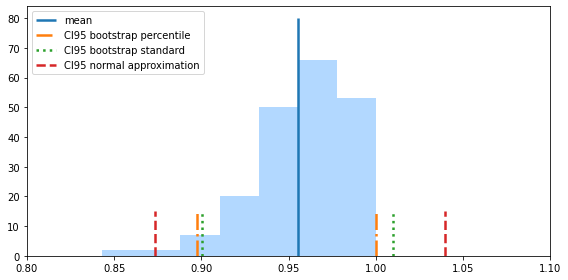

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(mean, [0], 80, lw=2.5, linestyle='-', label='mean')
#ax.vlines(med, [0], 60, lw=2.5, linestyle='--', label='median')
ax.vlines(lower, [0], 15, lw=2.5, linestyle='dashdot', label='CI95 bootstrap percentile', color='C1')
ax.vlines(upper, [0], 15, lw=2.5, linestyle='dashdot', color='C1')

ax.vlines(mean + ci, [0], 15, lw=2.5, linestyle='dotted', label='CI95 bootstrap standard', color='C2')
ax.vlines(mean - ci, [0], 15, lw=2.5, linestyle='dotted', color='C2')

ax.vlines(acc + ci_na, [0], 15, lw=2.5, linestyle='dashed', label='CI95 normal approximation', color='C3')
ax.vlines(acc - ci_na, [0], 15, lw=2.5, linestyle='dashed', color='C3')




ax.hist(accuracies, bins=7,
        color='#0080ff', edgecolor="none", 
        alpha=0.3)
plt.legend(loc='upper left')

plt.xlim([0.8, 1.1])
plt.tight_layout()
#plt.savefig('figures/bootstrap-histo-1.svg')

plt.show()

### 5k MNIST Subset

In [22]:
from mlxtend.data import mnist_data
from sklearn.linear_model import LogisticRegression


X, y = mnist_data()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.15, 
                                                    random_state=12345,
                                                    stratify=y)


clf = LogisticRegression(penalty='l2', 
                           dual=False, 
                           tol=0.0001, 
                           C=0.000001, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           class_weight=None, 
                           random_state=12, 
                           solver='lbfgs', 
                           max_iter=1000, 
                           multi_class='multinomial', 
                           verbose=0, 
                           warm_start=False, 
                           n_jobs=1)

**Bootstrap**

(This may take a long time to run)

In [23]:
rng = np.random.RandomState(seed=12345)
idx = np.arange(y_train.shape[0])

accuracies = []

for i in range(200):
    
    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    test_idx = np.setdiff1d(idx, train_idx, assume_unique=False)
    
    boot_train_X, boot_train_y = X_train[train_idx], y_train[train_idx]
    boot_test_X, boot_test_y = X_train[test_idx], y_train[test_idx]
    
    clf.fit(boot_train_X, boot_train_y)
    acc = clf.score(boot_test_X, boot_test_y)
    accuracies.append(acc)
mean = np.mean(accuracies)

**Via T-distribution**

In [24]:
se = np.sqrt( (1. / (200-1)) * np.sum([(acc - mean)**2 for acc in accuracies])) 
ci = 1.97 * se

print(mean-ci, mean+ci)

0.8863052563299453 0.9118606377774637


**Percentile Method**

In [25]:
lower = np.percentile(accuracies, 2.5)
upper = np.percentile(accuracies, 97.5)

print(lower, upper)

0.8858318667656936 0.910716827053402


**Normal Approximation**

In [26]:
clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
ci_na = 1.96 * np.sqrt((acc*(1-acc)) / y_test.shape[0])

print(acc-ci_na, acc+ci_na)

0.8902534272387673 0.9310799060945659


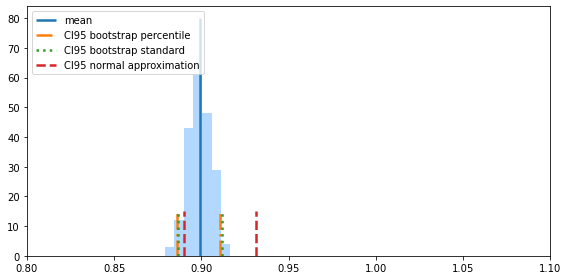

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(mean, [0], 80, lw=2.5, linestyle='-', label='mean')
#ax.vlines(med, [0], 60, lw=2.5, linestyle='--', label='median')
ax.vlines(lower, [0], 15, lw=2.5, linestyle='dashdot', label='CI95 bootstrap percentile', color='C1')
ax.vlines(upper, [0], 15, lw=2.5, linestyle='dashdot', color='C1')

ax.vlines(mean + ci, [0], 15, lw=2.5, linestyle='dotted', label='CI95 bootstrap standard', color='C2')
ax.vlines(mean - ci, [0], 15, lw=2.5, linestyle='dotted', color='C2')

ax.vlines(acc + ci_na, [0], 15, lw=2.5, linestyle='dashed', label='CI95 normal approximation', color='C3')
ax.vlines(acc - ci_na, [0], 15, lw=2.5, linestyle='dashed', color='C3')




ax.hist(accuracies, bins=7,
        color='#0080ff', edgecolor="none", 
        alpha=0.3)
plt.legend(loc='upper left')

plt.xlim([0.8, 1.1])
plt.tight_layout()
#plt.savefig('figures/bootstrap-histo-1.svg')

plt.show()

<br>
<br>
<br>

# 5. Out-of-Bag Bootstrap

In this section, we are going to look at the OOB bootstrap method, which I recently implemented in mlxtend.

In [28]:
from mlxtend.evaluate import BootstrapOutOfBag
import numpy as np




oob = BootstrapOutOfBag(n_splits=3, random_seed=1)
for train, test in oob.split(np.array([1, 2, 3, 4, 5])):
    print(train, test)

[3 4 0 1 3] [2]
[0 0 1 4 4] [2 3]
[1 2 4 2 4] [0 3]


The reason why I chose a object-oriented implementation is that we can plug it into scikit-learn's `cross_val_score` function, which is super convenient.

In [29]:
from mlxtend.data import iris_data
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

X, y = iris_data()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=123, stratify=y)


model = DecisionTreeClassifier(random_state=123)

Below, we are using the standard approach for `cross_val_score` first, which will perform 5-fold cross validation by setting `cv=5`. Note that 

- if the model is a scikit-learn classifier, stratified k-fold cross validation will be performed by default, and the reported evaluation metric is the prediction accuracy;
- if the model is a scikit-learn regressor, standard k-fold cross validation will be performed by default, and the reported evaluation metric is the $R^2$ score on the test folds.

In [30]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print('CV scores', cv_scores)
print('Mean CV score', np.mean(cv_scores))
print('CV score Std', np.std(cv_scores))

CV scores [0.94444444 1.         1.         0.88888889 0.94444444]
Mean CV score 0.9555555555555555
CV score Std 0.04157397096415492


Now, let's plug in our OOB object into the `cross_val_score` function:

In [31]:
# 5 splits

bootstrap_scores = \
    cross_val_score(model, X_train, y_train, 
                    cv=BootstrapOutOfBag(n_splits=5, random_seed=123))

print('Bootstrap scores', bootstrap_scores)
print('Mean Bootstrap score', np.mean(bootstrap_scores))
print('Score Std', np.std(bootstrap_scores))

Bootstrap scores [0.93548387 0.96774194 0.96875    0.93023256 0.97058824]
Mean Bootstrap score 0.9545593199770531
Score Std 0.017819915677477555


In [32]:
bootstrap_scores = \
    cross_val_score(model, X_train, y_train, 
                    cv=BootstrapOutOfBag(n_splits=200, random_seed=123))

print('Mean Bootstrap score', np.mean(bootstrap_scores))
print('Score Std', np.std(bootstrap_scores))

Mean Bootstrap score 0.9483980861793887
Score Std 0.039817322453014004


In [33]:
lower = np.percentile(bootstrap_scores, 2.5)
upper = np.percentile(bootstrap_scores, 97.5)
print('95%% Confidence interval: [%.2f, %.2f]' % (100*lower, 100*upper))

95% Confidence interval: [83.33, 100.00]


In [34]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.95

<br>
<br>
<br>

## MLxtend functional bootstrap API

###  OOB Bootstrap

Below is a more convenient way to compute the OOB Boostrap. Note that it has a tendency to be over-pessimistic.

In [35]:
from mlxtend.evaluate import bootstrap_point632_score

bootstrap_scores = bootstrap_point632_score(model, 
                                            X_train, y_train, 
                                            n_splits=200, 
                                            method='oob',
                                            random_seed=123)

print('Mean Bootstrap score', np.mean(bootstrap_scores))
print('Score Std', np.std(bootstrap_scores))

Mean Bootstrap score 0.9483980861793887
Score Std 0.039817322453014004


In [36]:
lower = np.percentile(bootstrap_scores, 2.5)
upper = np.percentile(bootstrap_scores, 97.5)
print('95%% Confidence interval: [%.2f, %.2f]' % (100*lower, 100*upper))

95% Confidence interval: [83.33, 100.00]


###  .632 Bootstrap

The .632 Bootstrap is the default setting of `bootstrap_point632_score`; it tends to be overly optimistic.

In [37]:
bootstrap_scores = bootstrap_point632_score(model, 
                                            X_train, y_train, 
                                            n_splits=200,
                                            random_seed=123)
print('Mean Bootstrap score', np.mean(bootstrap_scores))
print('Score Std', np.std(bootstrap_scores))

Mean Bootstrap score 0.9673875904653735
Score Std 0.02516454779030485


In [38]:
lower = np.percentile(bootstrap_scores, 2.5)
upper = np.percentile(bootstrap_scores, 97.5)
print('95%% Confidence interval: [%.2f, %.2f]' % (100*lower, 100*upper))

95% Confidence interval: [89.47, 100.00]


###  .632+ Bootstrap

The .632+ Boostrap method attempts to address the optimistic bias of the regular .632 Boostrap.

In [39]:
bootstrap_scores = bootstrap_point632_score(model, X_train, y_train, 
                                            n_splits=200, 
                                            method='.632+',
                                            random_seed=123)
print('Mean Bootstrap score', np.mean(bootstrap_scores))
print('Score Std', np.std(bootstrap_scores))

Mean Bootstrap score 0.9658029542600898
Score Std 0.027801366648921747


In [40]:
lower = np.percentile(bootstrap_scores, 2.5)
upper = np.percentile(bootstrap_scores, 97.5)
print('95%% Confidence interval: [%.2f, %.2f]' % (100*lower, 100*upper))

95% Confidence interval: [88.40, 100.00]
